# Assignment 2 Project A: Colon Cancer Image Classification

## Setup & Imports

In [509]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Directory paths
main = '../Image_classification_data/data_labels_mainData.csv'
extra = '../Image_classification_data/data_labels_extraData.csv'
img_dir = '../Image_classification_data/patch_images'


## 1. Load & Inspect Labels
### 1.1 Data Exploration and Understanding

#### Class Imbalance Identification

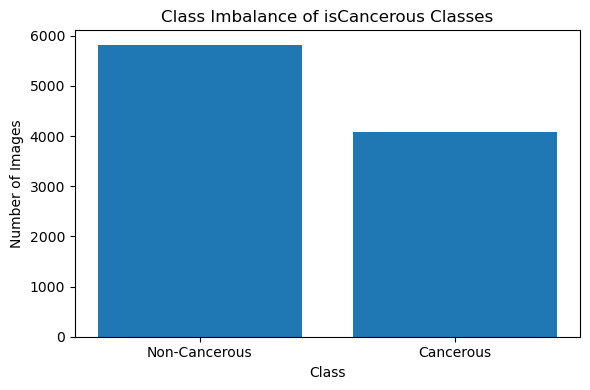

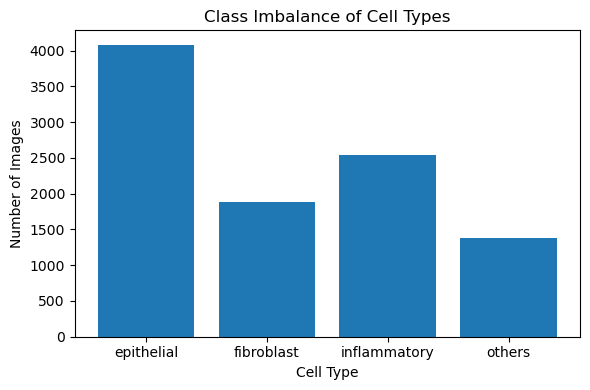

In [510]:
df_main = pd.read_csv(main)
df_extra = pd.read_csv(extra)

counts = df_main['isCancerous'].value_counts().sort_index()

class_names = ['Non-Cancerous', 'Cancerous']
counts.index = class_names

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values)
plt.title('Class Imbalance of isCancerous Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

counts = df_main['cellTypeName'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
bars = plt.bar(counts.index, counts.values)
plt.title('Class Imbalance of Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

- The above represents the class imbalances for isCancerous and cellTypeName, visualised through the bar graphs. The isCancerous class shows a clear imbalance in the count, as there are ~50% more non-cancerous compared to the cancerous.
- As for the cell types there is a clear disparancy between the **epithelial** cells and the rest, having twice the count compared to **fibroblast** and **others**. Also, being ~60% greater than the **inflammatory** cell.
- The difference in the count would lead to misleading accuracy towards the non-cancerous as it represents the majority of data and epithelial for the cell types. For data with fewer cases, models would tend to have low recall as there may not be enough information to be able to tell features apart leadning to worse generalisation.  



#### Exploratory Data Analysis (EDA)

In [511]:
df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [512]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In [513]:
df_main.isna()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
9891,False,False,False,False,False,False
9892,False,False,False,False,False,False
9893,False,False,False,False,False,False
9894,False,False,False,False,False,False


#### Justification of Data Handling Methods

## 3. Data Exploration & Understanding

In [514]:
# TODO: Visualize class imbalance for 'isCancerous'
# TODO: Visualize multiclass distribution for 'cellTypeName'
# TODO: Display sample images from each class


## 4. Evaluation Framework

In [515]:
# TODO: Split data by patient into train/val/test
# Ensure no leakage across splits
# TODO: Define evaluation metrics (e.g., macro-F1, precision, recall)


## 5. Model Baselines

### 5.1 ANN Baseline

In [516]:
# TODO: Define and compile a fully-connected ANN model


### 5.2 CNN Baseline

In [517]:
# TODO: Define and compile a CNN model


### 5.3 Decision Tree Baseline

In [518]:
# TODO: Define and train a DecisionTreeClassifier on flattened images


## 6. Optimization & Hyperparameter Tuning

In [519]:
# TODO: Plot learning curves to identify overfitting/underfitting
# TODO: Apply regularization techniques (dropout, weight decay)
# TODO: Use validation set for hyperparameter tuning


## 7. Final Performance & Robustness

In [520]:
# TODO: Evaluate chosen model on test set
# TODO: Assess robustness across patient subsets


## 8. Independent Evaluation

In [521]:
# TODO: Compare model performance to literature (e.g., Sirinukunwattana et al. 2016)


## 9. Conclusion & Ultimate Judgment

## Appendix
Detailed hyperparameters, extended results, and additional literature notes.